# Conditional Image Generation

In this notebook, we will extend the generative modeling framework from unconditional generation on simple toy datasets to conditional generation on images from the MNIST dataset. We will use classifier free guidance to achieve conditioning and the U-Net architecture to model high-dimensional image data.

## Import Required Libraries

In [1]:
!pip install -qU matplotlib numpy seaborn scikit-learn torch torchvision tqdm

In [2]:
# Abstract base classes (ABCs) and abstract methods define signatures without
# implementations, acting as templates that all subclasses must follow to be
# instantiated. Abstract methods are marked by the @abstractmethod decorator.
from abc import ABC, abstractmethod

# The Optional type hint specifies that a variable may be of a given type or of
# type None. Dict, List, and Tuple indicate containers parameterized by their
# constituent type(s), while Type denotes objects or subclasses of a specified
# type.
from typing import Optional, Dict, List, Tuple, Type

# The math module provides common mathematical functions and constants, NumPy
# enables efficient numerical computations, while tdqm displays a progress bar
# over loops and iterables.
import math, numpy as np
from tqdm import tqdm

# Matplotlib's pyplot provides a plotting interface. The Axes class represents
# an individual subplot within a Figure. Seaborn extends Matplotlib with addi-
# tional tools for statistical data visualization.
import matplotlib.pyplot as plt, matplotlib.axes._axes as Axes
import seaborn as sns

# PyTorch is a framework that facilitates the training of ML models. Its nn mo-
# dule provides the building blocks for working with neural networks, its dis-
# tributions module provides a wide range of probability distributions, and its
# func module provides higher-order function transforms. In particular, vectori-
# zing maps enable efficient batching of operations over multiple samples, while
# the Jacobian matrix contains the first-order partial derivatives of a function,
# i.e., partial f_i / partial x_j.
import torch, torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev

# The datasets package in TorchVision provides datasets for computer vision,
# while the transforms package provides image transforms and augmentations.
# The utils module provides helper utilities such as the ability to visualize
# images in a grid.
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# make_moons and make_circles create interleaving half circles and concentric
# circles, respectively. These represent binary classification datasets that
# are challenging for algorithms that rely on linear decision boundaries or
# centroid-based assumptions.
from sklearn.datasets import make_moons, make_circles

# Set the device to CUDA if a GPU is available; otherwise, fall back to the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams["font.family"] = "DejaVu Sans Mono"

In [3]:
class OldSampleable(ABC):
    """
    Distribution that can be sampled from.
    """
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Generate samples from the distribution.

        Parameters
        ----------
        num_samples : int
            Number of samples to generate (i.e., batch size)

        Returns
        -------
        samples : torch.Tensor, shape (num_samples, dim)
            Samples from the distribution.
        """
        pass

Because the MNIST dataset includes both images (handwritten digits) and class labels (integers from 0-9), the `Sampleable` class must be generalized to handle class labels. Therefore, the `sample` method should return both `samples: torch.Tensor` and `labels: Optional[torch.Tensor]`. In this way, each `Sampleable` instance represents sampling from a joint distribution over data and labels.

In [4]:
class Sampleable(ABC):
    """
    Distribution that can be sampled from, with optional class labels.
    """
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Generate samples from the distribution.

        Parameters
        ----------
        num_samples : int
            Number of samples to generate (i.e., batch size).

        Returns
        -------
        samples : torch.Tensor, shape (num_samples, sample_dim)
            Samples from the distribution.
        labels : Optional[torch.Tensor], shape (num_samples, label_dim)
            Class labels for each sample; None implies unlabeled data.
        """
        pass

For distributions such as Gaussians, there are no inherent class labels, so in those cases the associated class label is set to `None`.

In [5]:
class IsotropicGaussian(nn.Module, Sampleable):
    """
    Isotropic multivariate Gaussian distribution that can be sampled from.
    """
    def __init__(self, shape: List[int], std: float = 1.0):
        """
        Initialize a multivariate Gaussian distributed as N(0, std^2 * I).

        Parameters
        ----------
        shape : List[int]
            Shape of a single sample (excluding batch dimension).
        std : float, optional
            Standard deviation of each component. Default is 1.0.
        """
        super().__init__()
        self.shape = shape
        self.std = std
        # Dummy tensor used to track the module's device
        self.dummy = nn.Buffer(torch.zeros(1))

    def sample(self, num_samples) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Draw random samples from the multivariate Gaussian.

        Parameters
        ----------
        num_samples : int
            Number of samples to draw from the distribution.

        Returns
        -------
        samples : torch.Tensor, shape (num_samples, *shape)
            Samples from the distribution.
        labels : None
            Class labels are not defined for Gaussian samples.
        """
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device), None

In [6]:
class ConditionalProbabilityPath(nn.Module, ABC):
    """
    Abstract base class representing a conditional probability path p_t(x|z).
    Defines an interface for conditional probability paths that interpolate
    between an initial (noise) distribution and a target (data) distribution.
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        """
        Initialize the conditional probability path.

        Parameters
        ----------
        p_simple : Sampleable
            Initial (noise) distribution.
        p_data : Sampleable
            Target (data) distribution.
        """
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Sample from the marginal probability path,
        i.e., p_t(x) = int dz p_t(x|z) p_data(z).

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Continuous time points in [0, 1] corresponding to each sample.

        Returns
        -------
        x : torch.Tensor, shape (num_samples, channels, height, width)
            Samples from the marginal probability path p_t(x).
        """
        num_samples = t.shape[0]
        # Sample the conditioning variable z (given label y) ~ p_data(z, y) to
        # obtain data examples. Discard class labels.
        z, _ = self.sample_conditioning_variable(num_samples)
        # Conditioned on data examples, sample the conditional probability path
        # x ~ p_t(x|z) to obtain interpolated samples.
        x = self.sample_conditional_path(z, t)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Sample data examples z, given label y, from the data distribution
        p_data(z, y).

        Parameters
        ----------
        num_samples : int
            Number of data examples to draw.

        Returns
        -------
        z : torch.Tensor, shape (num_samples, channels, height, width)
            Data examples drawn from the data distribution p_data(z, y).
        y : torch.Tensor, shape (num_samples, label_dim)
            Corresponding class labels, if available. May be None for unlabeled
            data.
        """
        pass

    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Sample from the conditional probability path p_t(x|z) to obtain interpo-
        lated samples.

        Parameters
        ----------
        z : torch.Tensor, shape (num_samples, channels, height, width)
            Data examples drawn from the data distribution p_data(z, y).
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Continuous time points in [0, 1] corresponding to each sample.

        Returns
        -------
        x : torch.Tensor, shape (num_samples, channels, height, width)
            Interpolated samples drawn from p_t(x|z), representing intermediate
            states along the conditional probability path.
        """
        pass

    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the conditional vector field u_t(x|z), which describes the ins-
        tantaneous velocity of interpolated samples along the conditional path
        p_t(x|z).

        Parameters
        ----------
        x : torch.Tensor, shape (num_samples, channels, height, width)
            Interpolated samples drawn from p_t(x|z).
        z : torch.Tensor, shape (num_samples, channels, height, width)
            Conditioning variables, i.e., data examples drawn from p_data(z, y).
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Continuous time points in [0, 1] corresponding to each sample.

        Returns
        -------
        conditional_vector_field : torch.Tensor, shape (num_samples, channels, height, width)
            Values of the conditional vector field u_t(x|z).
        """
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the conditional score function nabla [ log p_t(x|z) ].

        Parameters
        ----------
        x : torch.Tensor, shape (num_samples, channels, height, width)
            Interpolated data samples drawn from p_t(x|z).
        z : torch.Tensor, shape (num_samples, channels, height, width)
            Conditioning variables, i.e., data examples drawn from p_data(z).
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Continuous time points in [0, 1] corresponding to each sample.

        Returns
        -------
        conditional_score : torch.Tensor, shape (num_samples, channels, height, width)
            Values of the conditional score function nabla [ log p_t(x|z) ].
        """
        pass

In [7]:
class Alpha(ABC):
    def __init__(self):
        # Enforce boundary conditions: alpha(0) = 0, alpha(1) = 1. self(t) eval-
        # uates alpha(t) on batched tensor input t of shape (num_samples, 1, 1,
        # 1).
        assert torch.allclose(self(torch.zeros(1, 1, 1, 1)), torch.zeros(1, 1, 1, 1))
        assert torch.allclose(self(torch.ones(1, 1, 1, 1)), torch.ones(1, 1, 1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluate alpha(t) for continuous time t in [0, 1].

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Time values in [0, 1] for which to compute alpha(t).

        Returns
        -------
        alpha_t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Computed alpha(t) values for each input time.
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the time derivative d/dt alpha(t).

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Time values in [0, 1] for which to compute alpha'(t).

        Returns
        -------
        dt : torch.Tensor, shape (num_samples, 1, 1, 1)
            alpha'(t) evaluated at the given time points.
        """
        # Expand t to shape (num_samples, 1, 1, 1, 1) so that each vmap slice
        # has shape (1, 1, 1, 1), matching the input shape expected by __call__.
        t = t.unsqueeze(1)
        # self(t) preserves shape: (1, 1, 1, 1). The Jacobian for each sample
        # is then of shape (1, 1, 1, 1, 1, 1, 1, 1), while vmap over the batch
        # dimension yields (num_samples, 1, 1, 1, 1, 1, 1, 1, 1).
        dt = vmap(jacrev(self))(t)
        # Flatten batched Jacobian to (num_samples, 1, 1, 1).
        return dt.view(-1, 1, 1, 1)

In [8]:
class Beta(ABC):
    def __init__(self):
        # Enforce boundary conditions: beta(0) = 1, beta(1) = 0.
        assert torch.allclose(self(torch.zeros(1, 1, 1, 1)), torch.ones(1, 1, 1, 1))
        assert torch.allclose(self(torch.ones(1, 1, 1, 1)), torch.zeros(1, 1, 1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluate beta(t) for continuous time t in [0, 1].

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Time values in [0, 1] for which to compute beta(t).

        Returns
        -------
        beta_t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Computed beta(t) values for each input time.
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the time derivative d/dt beta(t).

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Time values in [0, 1] for which to compute beta'(t).

        Returns
        -------
        dt : torch.Tensor, shape (num_samples, 1, 1, 1)
            beta'(t) evaluated at the given time points.
        """
        # Expand t to shape (num_samples, 1, 1, 1, 1) so that each vmap slice
        # has shape (1, 1, 1, 1), matching the input shape expected by __call__.
        t = t.unsqueeze(1)
        # Jacobian for each sample is of shape (1, 1, 1, 1, 1, 1, 1, 1), while
        # vmap over the batch dimension yields (num_samples, 1, 1, 1, 1, 1, 1,
        # 1, 1).
        dt = vmap(jacrev(self))(t)
        # Flatten batched Jacobian to (num_samples, 1, 1, 1).
        return dt.view(-1, 1, 1, 1)

In [9]:
class LinearAlpha(Alpha):
    """
    Linear alpha schedule defined by alpha(t) = t.
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluate alpha(t) for continuous time t in [0, 1].

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Time values in [0, 1] for which to compute alpha(t).

        Returns
        -------
        alpha_t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Computed alpha(t) values for each input time.
        """
        return t.clone()

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the time derivative d/dt alpha(t).

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Time values in [0, 1] for which to compute alpha'(t).

        Returns
        -------
        dt : torch.Tensor, shape (num_samples, 1, 1, 1)
            alpha'(t) evaluated at the given time points.
        """
        return torch.ones_like(t)

In [10]:
class LinearBeta(Beta):
    """
    Linear decay beta schedule defined by beta(t) = 1 - t.
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluate beta(t) for continuous time t in [0, 1].

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Time values in [0, 1] for which to compute beta(t).

        Returns
        -------
        beta_t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Computed beta(t) values for each input time.
        """
        beta_t = 1 - t
        return beta_t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the time derivative d/dt beta(t).

        Parameters
        ----------
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Time values in [0, 1] for which to compute beta'(t).

        Returns
        -------
        dt : torch.Tensor, shape (num_samples, 1, 1, 1)
            beta'(t) evaluated at the given time points.
        """
        dt = -torch.ones_like(t)
        return dt

In [11]:
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        """
        Initialize a Gaussian conditional probability path.

        Parameters
        ----------
        p_data : Sampleable
            Target data distribution.
        p_simple_shape : List[int]
            Shape of a single sample for the source distribution.
        alpha : Alpha
            Mean schedule.
        beta : Beta
            Variance schedule.
        """
        # Initialize the source distribution as N(0, I_d).
        p_simple = IsotropicGaussian(shape = p_simple_shape, std = 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Sample data examples z and labels y from the data distribution
        p_data(z, y).

        Parameters
        ----------
        num_samples : int
            Number of data examples to draw.

        Returns
        -------
        z : torch.Tensor, shape (num_samples, channels, height, width)
            Data examples drawn from the data distribution p_data(z, y).
        y : torch.Tensor, shape (num_samples, label_dim)
            Corresponding class labels, if available. May be None for unlabeled
            data.
        """
        return self.p_data.sample(num_samples)

    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Sample from the conditional probability path p_t(x|z) = N(alpha_t * z,
        beta_t^2 * I_d).

        Parameters
        ----------
        z : torch.Tensor, shape (num_samples, channels, height, width)
            Data examples drawn from the data distribution p_data(z).
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Continuous time points in [0, 1] corresponding to each sample.

        Returns
        -------
        x : torch.Tensor, shape (num_samples, channels, height, width)
            Interpolated samples drawn from p_t(x|z), representing states along
            the conditional probability path at times t.
        """
        location = self.alpha(t) * z
        scale = self.beta(t) * torch.randn_like(z)
        x = location + scale
        return x

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the conditional Gaussian vector field u_t(x|z).

        Parameters
        ----------
        x : torch.Tensor, shape (num_samples, channels, height, width)
            Interpolated samples drawn from p_t(x|z), representing states along
            the conditional probability path.
        z : torch.Tensor, shape (num_samples, channels, height, width)
            Data examples drawn from the data distribution p_data(z).
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Continuous time points in [0, 1) corresponding to each sample.

        Returns
        -------
        conditional_vector_field : torch.Tensor, shape (num_samples, channels, height, width)
            Values of the conditional vector field u_t(x|z).
        """
        z_term = (self.alpha.dt(t) - self.beta.dt(t) / self.beta(t) * self.alpha(t)) * z
        x_term = (self.beta.dt(t) / self.beta(t)) * x
        conditional_vector_field = z_term + x_term
        return conditional_vector_field

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the conditional score nabla [ log p_t(x|z) ] for the Gaussian
        conditional probability path.

        Parameters
        ----------
        x : torch.Tensor, shape (num_samples, channels, height, width)
            Interpolated samples drawn from p_t(x|z), representing states along
            the conditional probability path.
        z : torch.Tensor, shape (num_samples, channels, height, width)
            Data examples drawn from the data distribution p_data(z).
        t : torch.Tensor, shape (num_samples, 1, 1, 1)
            Continuous time points in [0, 1) corresponding to each sample.

        Returns
        -------
        conditional_score : torch.Tensor, shape (num_samples, channels, height, width)
            Values of the conditional score function nabla [ log p_t(x|z) ].
        """
        conditional_score = (self.alpha(t) * z - x) / (self.beta(t) ** 2)
        return conditional_score

In [12]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Return the drift coefficient of an ODE at the given states and times.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, channels, height, width)
            Current states x_t for each sample in the batch.
        t : torch.Tensor, shape (batch_size, 1, 1, 1)
            Time associated with each sample in the batch.

        Returns
        -------
        drift_coefficient : torch.Tensor, shape (batch_size, channels, height, width)
            Drift coefficients u_t(x_t) evaluated at the given times.
        """
        pass

In [13]:
class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of an SDE at the given states and times.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, channels, height, width)
            Current states x_t for each sample in the batch.
        t : torch.Tensor, shape (batch_size, 1, 1, 1)
            Time associated with each sample in the batch.

        Returns
        -------
        drift_coefficient : torch.Tensor, shape (batch_size, channels, height, width)
            Drift coefficients u_t(x_t) evaluated at the given times.
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the diffusion coefficient of an SDE at the given states and times.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, channels, height, width)
            Current states x_t for each sample in the batch.
        t : torch.Tensor, shape (batch_size, 1, 1, 1)
            Time associated with each sample in the batch.

        Returns
        -------
        diffusion_coefficient : torch.Tensor, shape (batch_size, channels, height, width)
            Diffusion coefficients sigma_t(x_t) evaluated at the given times.
        """
        pass

In [14]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        """
        Advance the simulation by one time step.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, channels, height, width)
            Current states x_t for each sample.
        t : torch.Tensor, shape (batch_size, 1, 1, 1)
            Current time for each sample.
        dt : torch.Tensor, shape (batch_size, 1, 1, 1)
            Time increment for each sample.

        Returns
        -------
        nxt : torch.Tensor, shape (batch_size, channels, height, width)
            Updated states at times t + dt.
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Perform the simulation across all time steps.

        Parameters
        ----------
        x_init : torch.Tensor, shape (batch_size, channels, height, width)
            Initial states at time ts[:, 0].
        ts : torch.Tensor, shape (batch_size, num_timesteps, 1, 1, 1)
            Monotonically increasing time grid for each sample.

        Returns
        -------
        x_final : torch.Tensor, shape (batch_size, channels, height, width)
            States at the final time ts[:, -1]
        """
        num_timesteps = ts.shape[1]
        for t_idx in tqdm(range(num_timesteps - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Run the simulation and record the entire trajectory.

        Parameters
        ----------
        x_init : torch.Tensor, shape (batch_size, channels, height, width)
            Initial states at time ts[:, 0].
        ts : torch.Tensor, shape (batch_size, num_timesteps, 1, 1, 1)
            Monotonically increasing time grid for each sample.

        Returns
        -------
        xs : torch.Tensor, shape (batch_size, num_timesteps, channels, height, width)
            Sequence of states at each recorded time step, including the initial
            states at ts[:, 0].
        """
        xs = [x.clone()]
        num_timesteps = ts.shape[1]
        for t_idx in tqdm(range(num_timesteps - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            xs.append(x.clone())
        return torch.stack(xs, dim = 1)

In [15]:
class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.ode.drift_coefficient(xt, t, **kwargs) * h

In [16]:
class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        drift = self.sde.drift_coefficient(xt, t, **kwargs) * h
        diffusion = self.sde.diffusion_coefficient(xt, t, **kwargs) * torch.sqrt(h) * torch.randn_like(xt)

        return xt + drift + diffusion

In [17]:
def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute indices to record in a trajectory. If record_every is 1, return all
    time steps from 0 to num_timesteps - 1.

    Otherwise, return every record_every-th time step starting from 0, always
    including the final time step (num_timesteps - 1).
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat([torch.arange(0, num_timesteps - 1, record_every),
                      torch.tensor([num_timesteps - 1])])

To train the model, we first need to define a helper function that returns model sizes in bytes.

In [18]:
# Convert bytes to mebibytes (MiB)
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> int:
    """
    Compute the total size of a PyTorch model in bytes. This is calculated as
    the sum, over all module parameters and buffers, of the number of elements
    in each parameter or buffer, multiplied by the size of each element in bytes.

    Parameters
    ----------
    model : torch.nn.Module
        Model whose parameters and buffers will be measured.

    Returns
    -------
    size : int
        Total size of all parameters and buffers, in bytes.
    """
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buffer in model.buffers():
        size += buffer.nelement() * buffer.element_size()
    return size

In [19]:
class Trainer(ABC):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        """
        Return an Adam optimizer for the model with the given learning rate.
        """
        return torch.optim.Adam(self.model.parameters(), lr = lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        """
        Train the model for the specified number of epochs with the given lear-
        ning rate.
        """
        # Report model size in MiB.
        size_b = model_size_b(self.model)
        print(f"Model Size: {size_b / MiB:.3f} MiB")

        # Move the model to the GPU if available, retrieve the optimizer, and
        # set the model to training mode (note that this must be done before
        # starting the training loop).
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # For each training epoch, reset the gradients to zero, compute the
        # training loss, and take its gradient with respect to the each weight
        # or bias (stored in their respective .grad attributes). Update model
        # parameters using the gradients.
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description_str(f"Epoch {idx}, Loss: {loss.item()}")

        # Set the model to evaluation mode for validation, testing, or inference
        self.model.eval()

## MNIST

Let us start by gaining some intuition for the [MNIST][mnist] dataset.

[mnist]: https://docs.pytorch.org/vision/0.24/generated/torchvision.datasets.MNIST.html

In [20]:
class MNISTSampler(nn.Module, Sampleable):
    """
    Wrapper around the MNIST dataset that enables random sampling of image-label
    pairs.
    """
    def __init__(self):
        """
        Initialize MNIST training set with preprocessing transforms.
        """
        super().__init__()
        # Load the MNIST training split with the following preprocessing trans-
        # forms: upscale each image to 32 x 32 pixels, convert to PyTorch ten-
        # sors and rescale pixel intensities from [0, 255] to [0, 1], and nor-
        # malize pixel intensities to [-1, 1].
        self.dataset = datasets.MNIST(root = "./data", train = True, download = True,
                                      transform = transforms.Compose([transforms.Resize((32, 32)),
                                                                      transforms.ToTensor(),
                                                                      transforms.Normalize((0.5, ), (0.5, ))]))
        # Dummy tensor used to track the module's computational device.
        self.dummy = nn.Buffer(torch.zeros(1))

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Draw a random subset of samples from the MNIST training set.

        Parameters
        ----------
        num_samples : int
            Number of samples to draw. Must not exceed dataset size.

        Returns
        -------
        samples : torch.Tensor, shape (batch_size, channels, height, width)
            Batch of images from the MNIST training set, with pixel values nor-
            malized to [-1, 1].
        labels : torch.Tensor, shape (batch_size, label_dim)
            Integer class labels (0-9) for each sample.
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")

        # Generate a random permutation of sample indices
        indices = torch.randperm(len(self.dataset))[:num_samples]
        # Each dataset element is an (image, label) pair; separate and collect
        # them.
        samples, labels = zip(*[self.dataset[i] for i in indices])
        # Stack samples and labels into new tensors, and move to the module's
        # device
        samples = torch.stack(samples).to(self.dummy)
        labels = torch.tensor(labels, dtype = torch.int64).to(self.dummy.device)
        return samples, labels

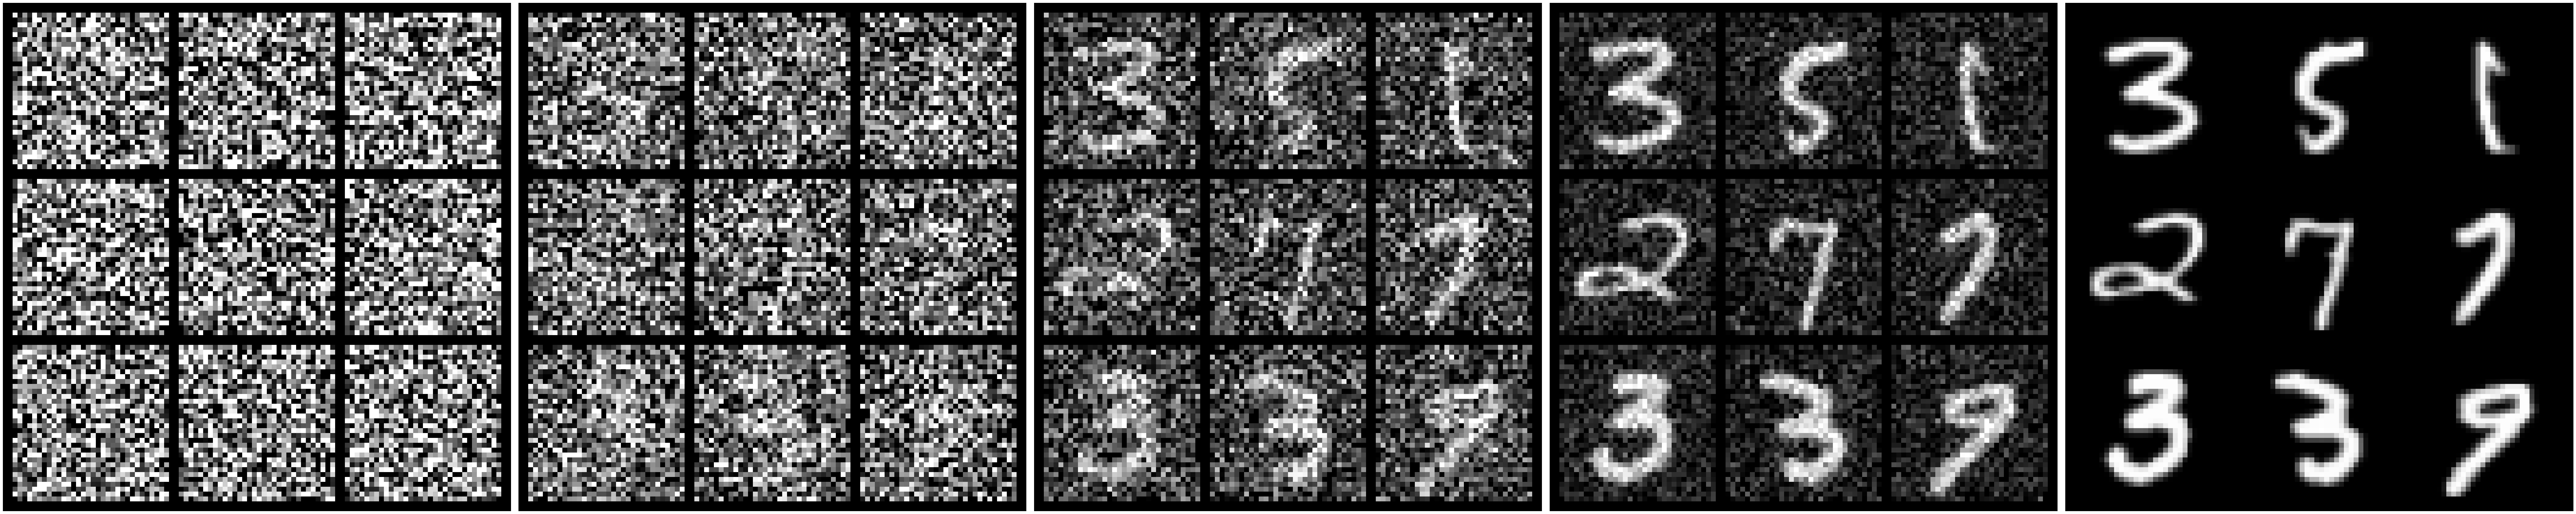

In [21]:
num_rows = 3
num_cols = 3
num_timesteps = 5

# Initialize the MNIST sampler, this forms the target (data) distribution
sampler = MNISTSampler().to(device)
path = GaussianConditionalProbabilityPath(p_data = sampler,
                                          p_simple_shape = [1, 32, 32],
                                          alpha = LinearAlpha(),
                                          beta = LinearBeta()).to(device)

num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 32, 32)

fig, axes = plt.subplots(1, num_timesteps, figsize = (6 * num_cols * num_timesteps, 6 * num_rows))

# Transform isotropic Gaussian noise to sampled MNIST digits using a Gaussian
# conditional probability path p_t(x|z) = N[t * z, (1 - t)^2 * I_d]
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1, 1, 1, 1).expand(num_samples, 1, 1, 1)
    xt = path.sample_conditional_path(z, tt)
    grid = make_grid(xt, nrow = num_cols, normalize = True, value_range = (-1, 1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap = "gray")
    axes[tidx].axis("off")
fig.tight_layout()

## Classifier Free Guidance

In unconditional generation, the goal is to produce any valid sample $-$ for example, any handwritten digit. In contrast, _conditional image generation_ allows us to specify a desired label for the generated image. Let $x\in\mathbb R^{1\times 32\times 32}$ represent the image (i.e., a digit) and let $y\in\{0, 1, \dots, 9\}$ denote the conditioning label that identifies which digit we want to generate. By fixing our choice of $y$ and considering the corresponding conditional data distribution $p_\mathrm{data}(x\vert y)$, we reduce the conditional generation problem to the unconditional case for that specific class.

We start by constructing a conditional flow matching objective as follows:
$$
\begin{align*}
\mathcal L_\mathrm{CFM}^\mathrm{guided}(\theta; y) & = \mathrm{E}_{\Box}\left[\left\lvert u_t^\theta(x\vert y) - u_t^\mathrm{target}(x\vert z)\right\rvert^2\right] \\
\Box & = z\sim p_\mathrm{data}(z\vert y), x\sim p_t(x\vert z)
\end{align*}
$$

We then let $y$ vary by taking the expectation _over_ $y$ (rather than fixing on a single value of $y$) and by conditioning the neural network approximation of the flow field $u_t^\theta(x\vert y)$ on $y$. This yields the guided conditional flow matching objective.
$$
\begin{align*}
\mathcal L^\mathrm{guided}_\mathrm{CFM}(\theta) & = \mathrm{E}_{\Box}\left[\left\lvert u_t^\theta(x\vert y) - u_t^\mathrm{target}(x\vert z)\right\rvert^2\right] \\
\Box & = (z, y) \sim p_\mathrm{data}(z, y), x\sim p_t(x\vert z)
\end{align*}
$$

We obtain $(z, y)\sim p_\mathrm{data}(z, y)$ by sampling an image $z$ and label $y$ from the labeled (MNIST) dataset. However, while this approach is theoretically valid, it was empirically realized that images sampled with this procedure do not fit well enough to the desired label $y$. By artificially reinforcing the effect of the guidance variable $y$, it was found that the perceptual quality is increased. This procedure is known as _classifier-free guidance_.

Let us develop guidance for Gaussian conditional probability paths. Paralleling the conditional vector field
$$
u_t^\mathrm{target}(x\vert z) = \left(\frac{\beta_t^2\dot\alpha_t - \alpha_t\dot\beta_t\beta_t}{\alpha_t}\right)\nabla\log p_t(x\vert z) + \frac{\dot\alpha_t}{\alpha_t}x,
$$
the guided vector field follows
$$
\begin{align*}
u_t^\mathrm{target}(x\vert y) = \left(\frac{\beta_t^2\dot\alpha_t - \alpha_t\dot\beta_t\beta_t}{\alpha_t}\right)\nabla\log p_t(x\vert y) + \frac{\dot\alpha_t}{\alpha_t}x.
\end{align*}
$$
Since
$$
\begin{align*}
\nabla\log p_t(x\vert y) & = \nabla\log\left[\frac{p_t(x)p_t(y\vert x)}{p_t(y)}\right] = \nabla\log p_t(x) + \nabla\log p_t(y\vert x),
\end{align*}
$$
we may rewrite
\begin{align*}
u_t^\mathrm{target}(x\vert y) & = \left(\frac{\beta_t^2\dot\alpha_t - \alpha_t\dot\beta_t\beta_t}{\alpha_t}\right)\left[\nabla\log p_t(x) + \nabla\log p_t(y\vert x)\right] + \frac{\dot\alpha_t}{\alpha_t}x \\
& = u_t^\mathrm{target}(x) + \left(\frac{\beta_t^2\dot\alpha_t - \alpha_t\dot\beta_t\beta_t}{\alpha_t}\right)\nabla\log p_t(y\vert x)
\end{align*}

The guided vector field $u_t^\mathrm{target}(x\vert y)$ is therefore the sum of an unguided vector field $u_t^\mathrm{target}(x)$ plus the gradient of the likelihood $\nabla\log p_t(y\vert x)$ of the guidance variable $y$, which may be considered a noisy classifier (given an image, what is the label). We then tune the strength of this classifier term by scaling
$$
\begin{align*}
\tilde{u}_t^\mathrm{target}(x\vert y) & = u_t^\mathrm{target}(x) + wb_t\nabla\log p_t(y\vert x) \\
b_t & = \left(\frac{\beta_t^2\dot\alpha_t - \alpha_t\dot\beta_t\beta_t}{\alpha_t}\right),
\end{align*}
$$
where $w > 1$ is the _guidance scale_. A simple rearrangement then yields
$$
\begin{align*}
\tilde{u}_t^\mathrm{target}(x\vert y) & = u_t^\mathrm{target}(x) + wb_t\nabla\log p_t(y\vert x) \\
& = u_t^\mathrm{target}(x) + w\big[u_t^\mathrm{target}(x\vert y) - u_t^\mathrm{target}(x)\big] \\
& = (1 - w)u_t^\mathrm{target}(x) + wu_t^\mathrm{target}(x\vert y).
\end{align*}
$$

We must therefore train both an unguided $u_t^\mathrm{target}(x)$ as well as a guided $u_t^\mathrm{target}(x\vert y)$, before combining them at inference time to obtain $\tilde u_t^\mathrm{target}(x\vert y)$. A straightforward way to do this would be to train two separate networks: one modeling $u_t^\theta(x)\approx u_t^\mathrm{target}(x)$ and another modeling $u_t^\theta(x\vert y)\approx u_t^\mathrm{target}(x\vert y)$, before sampling with $\tilde u_t^\mathrm{target}(x\vert y)$ at inference time.

However, this approach turns out to be unnecessary: by extending the label set to include an additional $\varnothing$ label that denotes the absence of conditioning, we may define $u_t^\mathrm{target}(x) = u_t^\mathrm{target}(x\vert y = \varnothing)$ and eliminate the need to train a separate unconditional model. The set of labels then becomes $y\in\{0, 1, \dots, 9, \varnothing\}$, and we obtain $\tilde{u}_t^\mathrm{target}(x\vert y) = (1 - w)u_t^\mathrm{target}(x\vert\varnothing) + wu_t^\mathrm{target}(x\vert y)$.

When sampling $(z, y)$ from the MNIST dataset $p_\mathrm{data}$, we never obtain $y = \varnothing$ directly, so this possibility must be introduced artificially. We define the hyperparameter $\eta$ to be the _probability_ that we discard the original label $y$ and replace it with $\varnothing$. The conditional flow matching objective for classifier-free guidance therefore follows
$$
\begin{align*}
\mathcal L^\mathrm{CFG}_\mathrm{CFM}(\theta) & = \mathrm{E}_{\Box}\left[\left\lvert u_t^\theta(x\vert y) - u_t^\mathrm{target}(x\vert z)\right\rvert^2\right] \\
\Box & = (z, y) \sim p_\mathrm{data}(z, y), x\sim p_t(x\vert z), t\sim\mathcal U[0, 1), \text{replace $y = \varnothing$ with probability $\eta$}.
\end{align*}
$$

In practice, to represent the null label $\varnothing$, we may assign it to an index, e.g., $\varnothing = 10$, and map this index to an embedding (higher-dimensional numerical representation). The training procedure is therefore as follows:

1. Sample an image $z$ and label $y$ from $p_\mathrm{data}$ (e.g., MNIST dataset).
2. With probability $\eta$, replace the label $y$ with the null label $\varnothing\overset{\Delta}{=} 10$.
3. Sample a time step $t$ from $\mathcal U[0, 1]$.
4. Sample an interpolated image $x$ from the conditional probability path $p_t(x\vert z)$.
5. Regress $u_t^\theta(x\vert y)$ against $u_t^\mathrm{target}(x\vert z)$.

In [22]:
class ConditionalVectorField(nn.Module, ABC):
    """
    Neural network parameterization u_t^theta(x|y) of the conditional vector
    field.
    """
    @abstractmethod
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, channels, height, width)
            Interpolated samples drawn from p_t(x|z), representing states along
            the conditional probability path.
        t : torch.Tensor, shape (batch_size, 1, 1, 1)
            Continuous time points in [0, 1) corresponding to each sample.
        y : torch.Tensor, shape (batch_size, 1)
            Class labels associated with the samples, used to condition the ge-
            nerative process.

        Returns
        -------
        u_t_theta : torch.Tensor, shape (batch_size, channels, height, width)
            Neural network approximation u_t^theta(x|y) of the conditional vec-
            tor field u_t(x|z).
        """
        pass

In [23]:
class CFGVectorFieldODE(ODE):
    def __init__(self, net: ConditionalVectorField, guidance_scale: float = 1.0):
        self.net = net
        self.guidance_scale = guidance_scale

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Compute the classifier-free guided vector field u_t^tilde(x|y) = (1 -
        w) * u_t(x|0) + w * u_t(x|y) for guidance scale w.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, channels, height, width)
            Interpolated samples drawn from p_t(x|z), representing states along
            the conditional probability path.
        t : torch.Tensor, shape (batch_size, 1, 1, 1)
            Continuous time points in [0, 1) corresponding to each sample.
        y : torch.Tensor, shape (batch_size, 1)
            Class labels associated with the samples, used to condition the ge-
            nerative process.

        Returns
        -------
        u_t_tilde : torch.Tensor, shape (batch_size, channels, height, width)
            Classifier-free guided vector field u_t^tilde(x|y).
        """
        guided_vector_field = self.net(x, t, y)
        unguided_y = torch.ones_like(y) * 10
        unguided_vector_field = self.net(x, t, unguided_y)
        return (1 - self.guidance_scale) * unguided_vector_field + self.guidance_scale * guided_vector_field

In [24]:
class CFGTrainer(Trainer):
    def __init__(self, path: GaussianConditionalProbabilityPath, model: ConditionalVectorField, eta: float, **kwargs):
        # Constrain the probability that we will discard the original label to
        # 0 < eta < 1.
        assert eta > 0 and eta < 1
        super().__init__(model, **kwargs)
        self.eta = eta
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z, y = self.path.p_data.sample(batch_size)

        mask = torch.rand(batch_size).to(device) < self.eta
        y[mask] = 10

        t = torch.rand(batch_size, 1, 1, 1).to(device)
        x = self.path.sample_conditional_path(z, t)

        u_t_theta = self.model(x, t, y)
        u_t_target = self.path.conditional_vector_field(x, z, t)
        loss = (u_t_theta - u_t_target).square().sum((1, 2, 3)).mean()

        return loss

## U-Net Architecture

Multilayer perceptrons, while sufficient for low-dimensional data distributions, struggle with complex, high-dimensional distributions, such as those over images, videos, and proteins. The U-Net architecture, originally designed for image segmentation (partitioning images into regions or objects), excels at extracting hierarchical spatial features while preserving fine spatial detail. Because of these properties, U-Nets are widely used by diffusion models during denoising (taking samples from noise to data), and by flow matching to learn the time-dependent velocity field.

Let us now build a U-Net model.

In [25]:
class FourierEncoder(nn.Module):
    """
    Embed normalized diffusion time step using learnable sinusoidal frequencies.
    Periodic encodings enable learning temporal structure at different scales:
    low frequencies capture early versus late denoising, while high frequencies
    distinguish adjacent time steps.
    """
    def __init__(self, dim: int):
        """
        Given an embedding dimension, initialize learnable frequency weights for
        sinusoidal time step encoding.
        """
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Convert normalized time steps into high-dimensional Fourier embeddings
        using the learnable frequencies.

        Parameters
        ----------
        t : torch.Tensor, shape (batch_size, 1, 1, 1)
            Continuous time points in [0, 1) corresponding to each sample.

        Returns
        -------
        embeddings : torch.Tensor, shape (batch_size, dim)
            Sinusoidal embeddings encoding relative temporal position.
        """
        t = t.view(-1, 1)
        # Convert the time step into frequencies 2 * pi * weight * t, then com-
        # pute the corresponding sinusoidal response at that frequency. The co-
        # sine embedding enables the model to represent phase shifts.
        freqs = 2 * math.pi * self.weights * t
        sin_embed = torch.sin(freqs)
        cos_embed = torch.cos(freqs)
        # The variance of each sine/cosine component is 1/2, so scale by sqrt(2)
        # to yield a variance of 1.
        embeddings = torch.cat([sin_embed, cos_embed], dim = -1) * math.sqrt(2)
        return embeddings

The residual layer takes an input image $x_t\in\mathbb R^{C_\mathrm{in}\times H\times W}$ and computes the cross-correlation between the input patch and corresponding kernel weight, i.e.,
$$
\begin{align*}
\mathrm{output}\big(C_\mathrm{out}, i, j\big)
& = \sum_{C_\mathrm{in}}\sum_{m = -1}^1\sum_{n = -1}^1\mathrm{input}\big(C_\mathrm{in}, i + m, j + n\big)
\times\mathrm{weight}\big(C_\mathrm{out}, C_\mathrm{in}, m + 1, n + 1\big)
+ \mathrm{bias}\big(C_\mathrm{out}\big) \\
& = \sum_{C_\mathrm{in}}\big[\mathrm{input}\big(C_\mathrm{in}\big)
\star\mathrm{weight}\big(C_\mathrm{out}, C_\mathrm{in}\big)\big]\big(i, j\big)
+ \mathrm{bias}\big(C_\mathrm{out}\big)
\end{align*}
$$
to obtain spatial features at each pixel location by performing a weighted aggregation of its local neighborhood.

Time and class information are converted into channel-specific modulations
that apply to every spatial location (pixel), i.e.,
$$
\begin{align*}
x_t &\leftarrow x_t + (Ay + b)^{H\times W} \\
y &\in\mathbb{R}^D \\
A &\in\mathbb{R}^{C_\mathrm{out}\times D} \\
b &\in\mathbb{R}^{C_\mathrm{out}}
\end{align*}
$$
where $D$ denotes the embedding dimension of the time step or class label,
and the weights $A$ and biases $b$ are learned by the neural network.

Convolution layers aggregate information over neighboring pixels, blurring high-frequency details such as edges. Furthermore, in deep (multi-layer) neural networks, the gradients of the loss with respect to early-layer parameters $\theta_n$ are frequently _vanishing_, i.e.,
$$
\begin{align*}
x_t^{n + 1} & = f\!\left(x_t^n, \theta_n\right) \\
\frac{\partial L}{\partial\theta_n} & = \frac{\partial L}{\partial x_t^{n + 1}}\frac{\partial x_t^{n + 1}}{\partial\theta_n} \\
\frac{\partial L}{\partial\theta_1} & = \frac{\partial L}{\partial x_t^N}\frac{\partial x_t^N}{\partial x_t^{N - 1}}\dots\frac{\partial x_t^3}{\partial x_t^2}\frac{\partial x_t^2}{\partial\theta_1} \\
\frac{\partial L}{\partial\theta_m}
& = \frac{\partial L}{\partial x_t^N}\left(\prod_{n = m + 1}^{N - 1}\frac{\partial x_t^{n + 1}}{\partial x_t^n}\right)\frac{\partial x_t^{m + 1}}{\partial\theta_m}
\end{align*}
$$
where _repeated_ derivatives of each layer's outputs with respect to its inputs $\displaystyle\frac{\partial x_t^{n + 1}}{\partial x_t^n} < 1$ causes error signals to decay exponentially as they backpropagate to earlier layers.

By adding a residual connection, i.e., $\displaystyle x^{n + 1}_t = f\!\left(x_t^n, \theta_n\right) + x_t^n$, we obtain
$$
\begin{align*}
\frac{\partial x_t^{n + 1}}{\partial x_t^n} = \frac{\partial f}{\partial x_t^n} + 1 \approx 1,
\end{align*}
$$
enabling us to update the parameters for earlier layers.

In [26]:
class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int, y_embed_dim: int):
        """
        Initialize a residual layer that processes image feature maps using con-
        volutional layers (sliding a learned filter / kernel to extract features),
        while incorporating auxiliary (time and class) embeddings.
        """
        super().__init__()
        # Add a SiLU activation y = x / [1 + exp(-x)] to introduce nonlinearity;
        # normalize for each channel across batch, height, width; and perform a
        # convolution for each channel, by applying a filter to the 3 x 3 grid
        # surrounding each pixel, and adding a 1-pixel padding to the boundary
        # to capture pixels at the perimeter.
        self.block1 = nn.Sequential(nn.SiLU(),
                                    nn.BatchNorm2d(channels),
                                    nn.Conv2d(channels, channels, kernel_size = 3, padding = 1))
        # Add a second convolutional block for use after incorporating time and
        # class embeddings.
        self.block2 = nn.Sequential(nn.SiLU(),
                                    nn.BatchNorm2d(channels),
                                    nn.Conv2d(channels, channels, kernel_size = 3, padding = 1))
        # Transform the time embedding by performing an affine transformation,
        # applying a non-linear activation (as otherwise, 2 linear transforma-
        # tions would collapse into 1), and projecting it onto each channel,
        # thereby encoding temporal information across channels.
        self.time_adapter = nn.Sequential(nn.Linear(time_embed_dim, time_embed_dim),
                                          nn.SiLU(),
                                          nn.Linear(time_embed_dim, channels))
        # Repeat for the class embedding.
        self.y_adapter = nn.Sequential(nn.Linear(y_embed_dim, y_embed_dim),
                                       nn.SiLU(),
                                       nn.Linear(y_embed_dim, channels))

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Combine visual features extracted from image feature maps with time step
        and class embeddings to form a joint representation. Apply a residual
        connection to mitigate vanishing gradients and preserve low-level vi-
        sual information.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, channels, height, width)
            Input feature maps.
        t_embed : torch.Tensor, shape (batch_size, t_embed_dim)
            Time step embeddings.
        y_embed : torch.Tensor, shape (batch_size, y_embed_dim)
            Class label embeddings for conditioning.

        Returns
        -------
        x : torch.Tensor, shape (batch_size, channels, height, width)
            Learned image features with projected time and class embeddings.
        """
        # Save the input as a residual tensor to add back later.
        residual = x.clone()
        # Apply the first convolutional block to extract visual features (e.g.,
        # edges, corners, textures, shapes) from the input.
        x = self.block1(x)
        # Project time embeddings onto channel space, before adding to the fea-
        # ture map.
        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1)
        x = x + t_embed
        # Repeat for class embeddings.
        y_embed = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1)
        x = x + y_embed
        # Process conditioned features through the second convolutional block,
        # before adding back the residual connection to stabilize gradients.
        x = self.block2(x)
        x = x + residual

        return x

In [27]:
class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        """
        Initialize an encoder composed of:

        1. Residual layers that learn hierarchical representations from input
           feature maps, while incorporating time step and class conditioning
           information.

        2. Downsampling convolution that reduces spatial resolution while adjus-
           ting the number of feature channels.
        """
        super().__init__()
        # Sequence of residual layers that extracts features from, and embeds
        # conditioning information within, image feature maps with the speci-
        # fied number of input channels. ModuleList enables iteration in a cus-
        # tom forward pass.
        self.res_blocks = nn.ModuleList([ResidualLayer(channels_in,
                                                       t_embed_dim,
                                                       y_embed_dim) for _ in range(num_residual_layers)])
        # Convolution that downsamples feature map to the specified number of
        # output channels. A stride of 2 means output dimensions are approxi-
        # mately halved, i.e., floor[(input + 1) / 2].
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size = 3, stride = 2, padding = 1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Pass input feature maps through residual layers with time / class condi-
        tioning, followed by downsampling convolution.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, channels_in, height_in, width_in)
            Input feature maps, with the specified number of channels.
        t_embed : torch.Tensor, shape (batch_size, t_embed_dim)
            Time step embeddings.
        y_embed : torch.Tensor, shape (batch_size, y_embed_dim)
            Class label embeddings for conditioning.

        Returns
        -------
        x : torch.Tensor, shape (batch_size, channels_out, height_out, width_out)
            Downsampled feature maps with the given number of output channels.
            Spatial dimensions are reduced by half, i.e., ceil(input / 2).
        """
        # Pass input feature maps through each residual layer. Output tensor
        # shape remains unchanged.
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        # Downsample feature map, reducing spatial dimensions by half, and
        # convert to output channels.
        x = self.downsample(x)
        return x

In [28]:
class Midcoder(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        """
        Initialize a midcoder with residual layers that learn hierarchical re-
        presentations from input feature maps, while incorporating time step
        and class conditioning.
        """
        super().__init__()
        self.res_blocks = nn.ModuleList([ResidualLayer(channels,
                                                       t_embed_dim,
                                                       y_embed_dim) for _ in range(num_residual_layers)])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Pass feature maps through residual layers with time / class conditioning.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, channels, height, width)
            Feature maps from prior convolutions.
        t_embed : torch.Tensor, shape (batch_size, t_embed_dim)
            Time step embeddings.
        y_embed : torch.Tensor, shape (batch_size, y_embed_dim)
            Class label embeddings for conditioning.

        Returns
        -------
        x : torch.Tensor, shape (batch_size, channels, height, width)
            Feature maps with learned hierarchical representations, in which the
            spatial dimension and channel count remain unchanged.
        """
        # Apply residual layers sequentially.
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)
        return x

In [29]:
class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        """
        Initialize a decoder composed of:

        1. Bilinear interpolation for smooth upsampling, doubling the spatial
           dimension, plus projection by a convolution layer onto the original
           (input) set of channels.

        2. Residual layers that learn hierarchical representations from feature
           maps, while incorporating time step and class conditioning.
        """
        super().__init__()
        self.upsample = nn.Sequential(nn.Upsample(scale_factor = 2, mode = "bilinear"),
                                      nn.Conv2d(channels_in, channels_out, kernel_size = 3, padding = 1))
        self.res_blocks = nn.ModuleList([ResidualLayer(channels_out,
                                                       t_embed_dim,
                                                       y_embed_dim) for _ in range(num_residual_layers)])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Upsample feature maps 2x spatially via bilinear interpolation, followed
        by convolution for projection onto the original (input) set of channels.
        Refine through residual layers with time / class conditioning.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, channels_in, height_in, width_in)
            Feature maps from prior convolutions.
        t_embed : torch.Tensor, shape (batch_size, t_embed_dim)
            Time step embeddings.
        y_embed : torch.Tensor, shape (batch_size, y_embed_dim)
            Class label embeddings for conditioning.

        Returns
        -------
        x : torch.Tensor, shape (batch_size, channels_out, height_out, width_out)
            Refined feature maps for progressive image generation, in which the
            spatial resolution is doubled and channel count is restored to match
            the input.
        """
        x = self.upsample(x)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)
        return x

In [30]:
class MNISTUNet(ConditionalVectorField):
    def __init__(self, channels: List[int], num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        """
        Initialize a U-Net to learn u_t^theta(x|y), which approximates the con-
        ditional vector field u_t(x|z), and guides samples from noise to data.

        Note that downsampling followed by upsampling helps capture both global
        structure and fine-grained detail, while maintaining computational effi-
        ciency.
        """
        super().__init__()
        # Initial convolution transforms grayscale inputs (1 channel) into fea-
        # ture maps, while preserving spatial resolution. Must precede normali-
        # zation / activation, as raw pixels lack structured features to norma-
        # lize.
        self.init_conv = nn.Sequential(nn.Conv2d(1, channels[0], kernel_size = 3, padding = 1),
                                       nn.BatchNorm2d(channels[0]),
                                       nn.SiLU())

        # Time step embedding uses sinusoidal (Fourier) features to encode tem-
        # poral position.
        self.time_embedder = FourierEncoder(t_embed_dim)

        # Class embedding encodes class labels (0, ..., 9, null) as continuous
        # vectors for conditional generation.
        self.y_embedder = nn.Embedding(num_embeddings = 11, embedding_dim = y_embed_dim)

        # Initialize encoders, a midcoder, and matching (symmetric) set of de-
        # coders to downsample and learn higher-level abstract features, increa-
        # sing the number of channels, before generating the image from the fea-
        # ture map. The midcoder processes the most abstract representation at
        # minimal spatial resolution to capture global context.
        encoders = []
        decoders = []
        for (curr_ch, next_ch) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_ch, next_ch, num_residual_layers, t_embed_dim, y_embed_dim))
            decoders.append(Decoder(next_ch, curr_ch, num_residual_layers, t_embed_dim, y_embed_dim))

        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))
        self.midcoder = Midcoder(channels[-1], num_residual_layers, t_embed_dim, y_embed_dim)

        # Final convolution produces 1-channel vector field prediction from de-
        # coded features.
        self.final_conv = nn.Conv2d(channels[0], 1, kernel_size = 3, padding = 1)

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Perform a forward pass through the MNIST U-Net to estimate the conditio-
        nal vector field that guides samples from noise to data.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, 1, 32, 32)
            Batch of MNIST images with one channel and 32×32 resolution.
        t : torch.Tensor, shape (batch_size, 1, 1, 1)
            Continuous time points in [0, 1) corresponding to each sample.
        y : torch.Tensor, shape (batch_size, )
            Class labels (0, ..., 9, null) used to condition the network and
            guide generation.

        Returns
        -------
        u_t_theta: torch.Tensor, shape (batch_size, 1, 32, 32)
            Neural network approximation u_t^theta(x|y) of the conditional vec-
            tor field u_t(x|z).
        """
        # Embed time step and class label into latent vectors.
        # t_embed: (batch_size, t_embed_dim)
        # y_embed: (batch_size, y_embed_dim)
        t_embed = self.time_embedder(t)
        y_embed = self.y_embedder(y)

        # Perform the initial convolution.
        # x: (batch_size, channels[0], 32, 32)
        x = self.init_conv(x)

        residuals = []
        # Each encoder downsamples and enriches features: (batch_size, channels[i],
        # height, width) to (batch_size, channels[i + 1], height // 2, width // 2)
        # from i = 0 to n - 1.
        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed)
            # Clone the feature map after encoding to add back later as a resi-
            # dual connection.
            residuals.append(x.clone())

        # Midcoder learns features at the most abstract representation, i.e.,
        # channels[-1].
        x = self.midcoder(x, t_embed, y_embed)

        # Add the corresponding encoder feature map as a residual connection be-
        # fore each decoder step. Each decoder upsamples (batch_size, channels[i],
        # height, width) to (batch_size, channels[i - 1], 2 * height, 2 * width)
        # for i = n to 1.
        for decoder in self.decoders:
            residual = residuals.pop()
            x = x + residual
            x = decoder(x, t_embed, y_embed)

        # Final convolution maps features back to the input resolution, producing
        # the predicted conditional vector field (batch_size, 1, 32, 32).
        x = self.final_conv(x)
        return x

In [31]:
# Guide samples from multivariate Gaussian noise to MNIST digits.
path = GaussianConditionalProbabilityPath(p_data = MNISTSampler(),
                                          p_simple_shape = [1, 32, 32],
                                          alpha = LinearAlpha(),
                                          beta = LinearBeta()).to(device)

# U-Net has 2 encoder blocks, 2 decoder blocks, and 1 midcoder block; each has 2
# residual layers.
unet = MNISTUNet(channels = [32, 64, 128],
                 num_residual_layers = 2,
                 t_embed_dim = 40,
                 y_embed_dim = 40)

# Replace class label with null label with probability 0.1.
trainer = CFGTrainer(path = path, model = unet, eta = 0.1)
trainer.train(num_epochs = 5000, device = device, lr = 1e-3, batch_size = 250)

Model Size: 4.715 MiB


Epoch 4999, Loss: 128.03677368164062: 5000it [24:47,  3.36it/s]


100%|██████████| 99/99 [00:05<00:00, 18.64it/s]


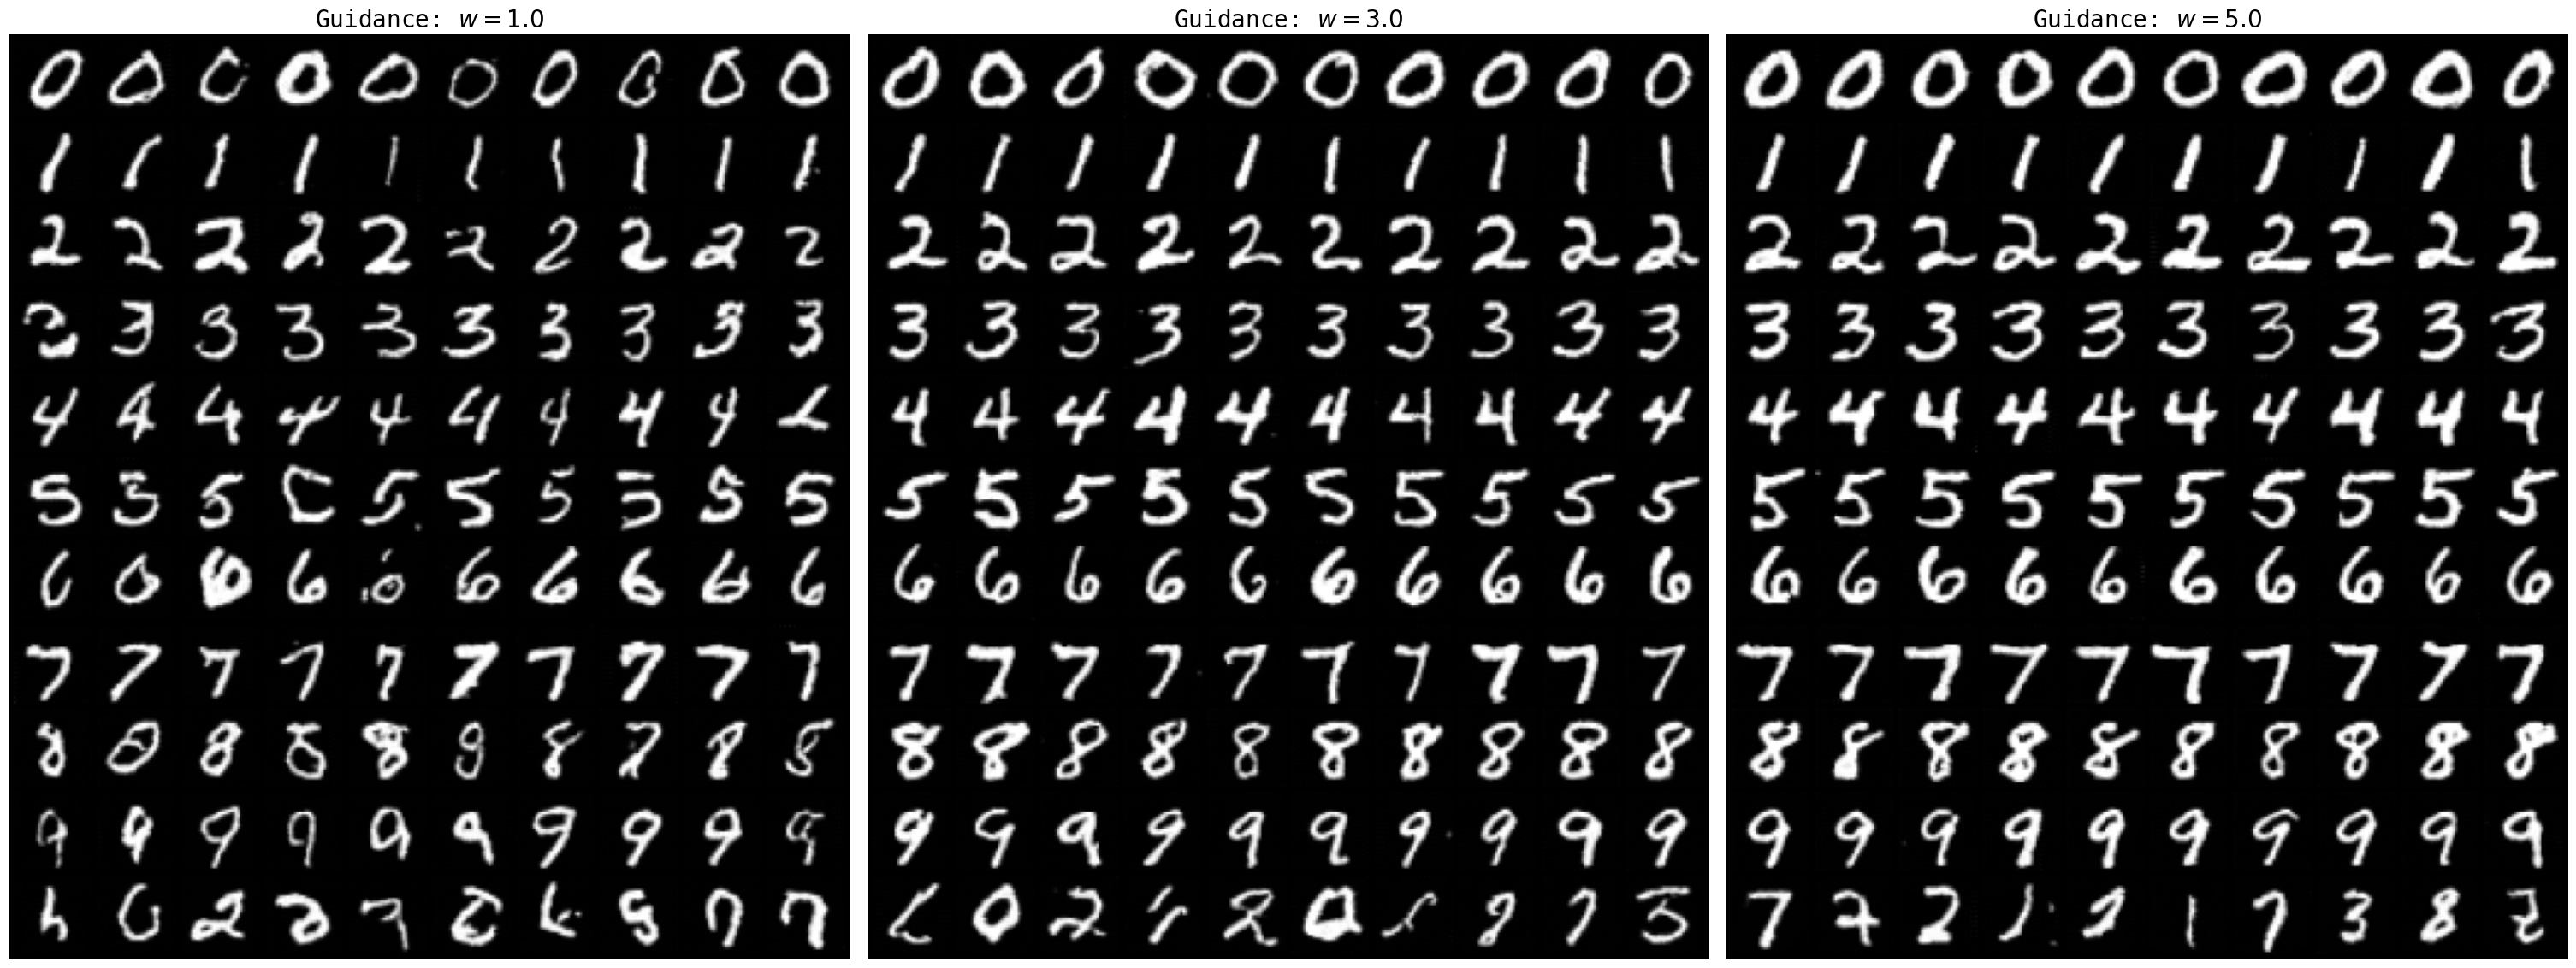

In [32]:
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]

fig, axes = plt.subplots(1, len(guidance_scales), figsize = (10 * len(guidance_scales), 12), constrained_layout = True)
for idx, w in enumerate(guidance_scales):
    # Create a classifier-free guided vector field with the specified guidance
    # scale, then simulate as an ODE.
    ode = CFGVectorFieldODE(unet, guidance_scale = w)
    simulator = EulerSimulator(ode)

    # Create 10 copies of each class label, then sample the starting noise dis-
    # tribution.
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples)

    # Simulate for the given number of time steps by the Euler method, then re-
    # turn the final state.
    ts = torch.linspace(0, 1, num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    x1 = simulator.simulate(x0, ts, y = y)

    # Visualize samples generated at each guidance scale.
    grid = make_grid(x1, nrow = samples_per_class, normalize = True, value_range = (-1, 1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap = "gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w = {w:.1f}$", fontsize = 20)

We observe that increasing the guidance scale reinforces the alignment of generated digits with their target class, by more strongly guiding the generated samples to match those drawn from the data distribution for that class.

The null class was trained by randomly dropping labels for samples at random, thereby creating an assorted mixture of all classes. Increasing the guidance scale simply reinforces the conditioning on a random set, and so produces no directional effect.